# Homogeneous Slab Test Case

This notebook tests the SN solver on a simple homogeneous slab problem with uniform material properties.

In [1]:
from SN1D import Material, Geo1D, Mesh1D, SNSolver, Diamond, DiamondFixup, Step
import matplotlib.pyplot as plt
import numpy as np

## Problem Setup

Define a homogeneous slab with:
- Uniform material properties
- Simple source distribution

In [2]:
# Material properties
sig_t = 1  # Total cross-section
c = 0.5  # Scattering ratio
sig_s = c * sig_t  # Scattering cross-section
sig_a = sig_t - sig_s  # Absorption cross-section

# Create homogeneous material
mat_homo = Material(sig_t, sig_a, sig_s, 0)

# Slab dimensions
slab_length = 10.0

# Define source function
def source_uniform(x):
    """Uniform source throughout the slab"""
    return 1.0

def source_centered(x):
    """Source concentrated in the center of the slab"""
    center = slab_length / 2
    width = 1.
    if abs(x - center) < width / 2:
        return 1.0
    return 0.0

# Choose source
source = source_uniform

## Geometry and Mesh Definition

In [3]:
# Create homogeneous geometry (single region)
geo = Geo1D([0., slab_length], [mat_homo])

def get_mesh(n_cells):
    """Create uniform mesh with n_cells"""
    mesh = Mesh1D([n_cells])
    return mesh

## Reference Solution

Compute a high-resolution reference solution for comparison.

Iterations: 14 error: 5.150057622138604e-05


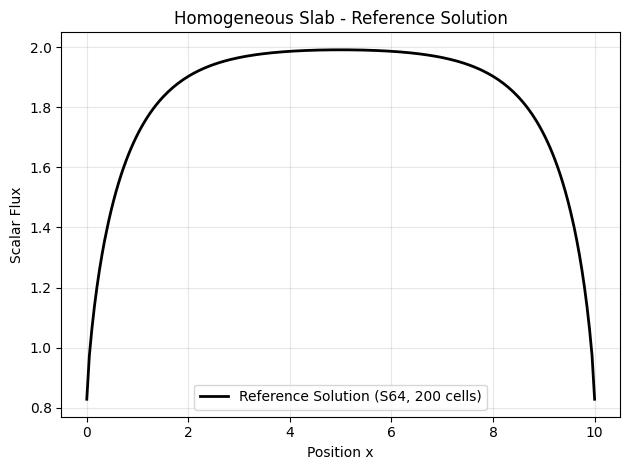

In [ ]:
# Reference solution with fine mesh and high SN order
mesh_ref = get_mesh(200)
solver_ref = SNSolver(geo, mesh_ref, source, sn=64)
flux_ref, x0_ref = solver_ref.solve()

plt.figure(figsize=(10, 6))
plt.plot(x0_ref, flux_ref, label='Reference Solution (S64, 200 cells)', color='black', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('Position x')
plt.ylabel('Scalar Flux')
plt.title('Homogeneous Slab - Reference Solution')
plt.legend()
plt.tight_layout()
plt.show()

## Angular Discretization Study

Compare different SN orders with fixed spatial mesh.

In [5]:
sn_orders = [2, 4, 8, 16, 32]
mesh_obj = get_mesh(100)
results = {}

for sn in sn_orders:
    solver = SNSolver(geo, mesh_obj, source, sn=sn)
    flux, mesh = solver.solve()
    results[sn] = (flux, mesh)

Iterations: 14 error: 5.0996789290547184e-05
Iterations: 14 error: 5.143035222587855e-05
Iterations: 14 error: 5.148094467721798e-05
Iterations: 14 error: 5.149478997568124e-05
Iterations: 14 error: 5.149811691551598e-05


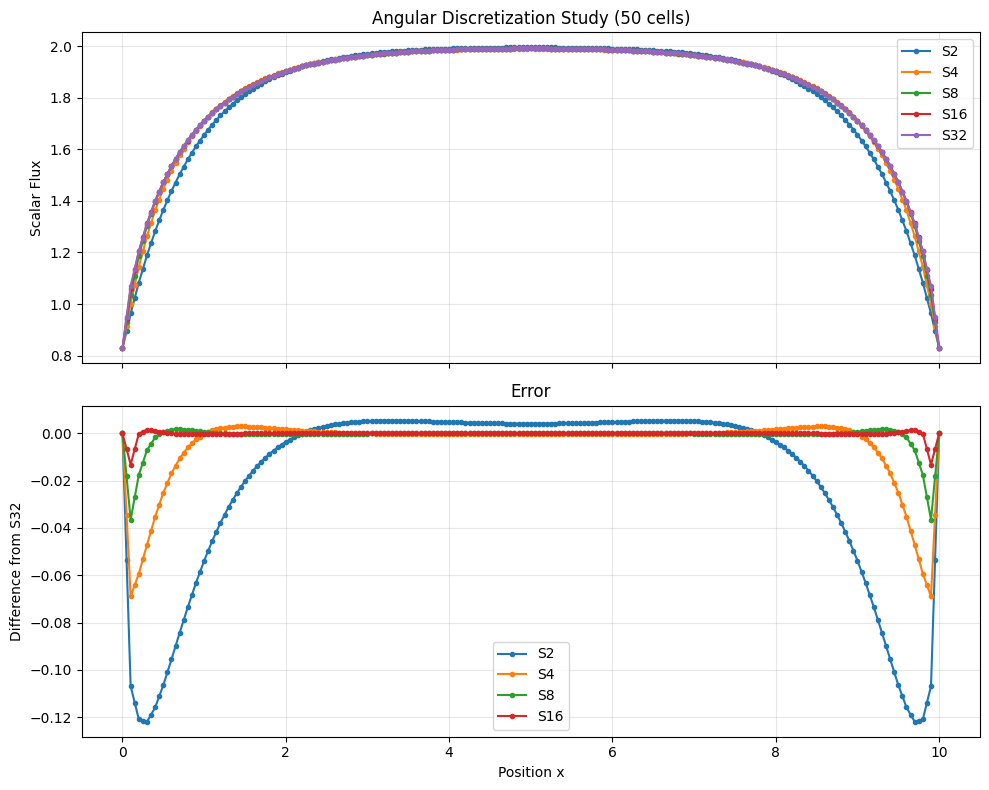

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
flux_ref, mesh_ref = results[32]

for sn in sn_orders:
    flux, mesh = results[sn]
    ax1.plot(mesh, flux, label=f"S{sn}", marker='.') #, markersize=3, markevery=5)
    
    # Compute difference from reference
    flux_interp = np.interp(mesh, mesh_ref, flux_ref)
    diff = flux - flux_interp
    #diff = (flux - flux_interp) / flux_interp
    if sn < 32:
        ax2.plot(mesh, diff, label=f"S{sn}", marker='.')

#ax1.plot(mesh_ref, flux_ref, label='Reference', color='black', linestyle='--', linewidth=2)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('Scalar Flux')
ax1.set_title('Angular Discretization Study (50 cells)')

ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Position x')
ax2.set_ylabel('Difference from S32')
ax2.set_title('Error')

plt.tight_layout()
plt.show()

## Spatial Discretization Study

Compare different mesh refinements with fixed SN order.

In [7]:
n_cells_list = [1, 2, 5, 10, 20, 50, 100]
sn_fixed = 16
results_mesh = {}

for n_cells in n_cells_list:
    mesh = get_mesh(n_cells)
    solver = SNSolver(geo, mesh, source, sn=sn_fixed)
    flux, mesh = solver.solve()
    results_mesh[n_cells] = (flux, mesh) 

Iterations: 12 error: 7.299066799082432e-05
Iterations: 13 error: 7.750527809502472e-05
Iterations: 14 error: 5.1715036463617636e-05
Iterations: 14 error: 5.124260236932798e-05
Iterations: 14 error: 5.144075899377043e-05
Iterations: 14 error: 5.1488188206327834e-05
Iterations: 14 error: 5.149478997568124e-05


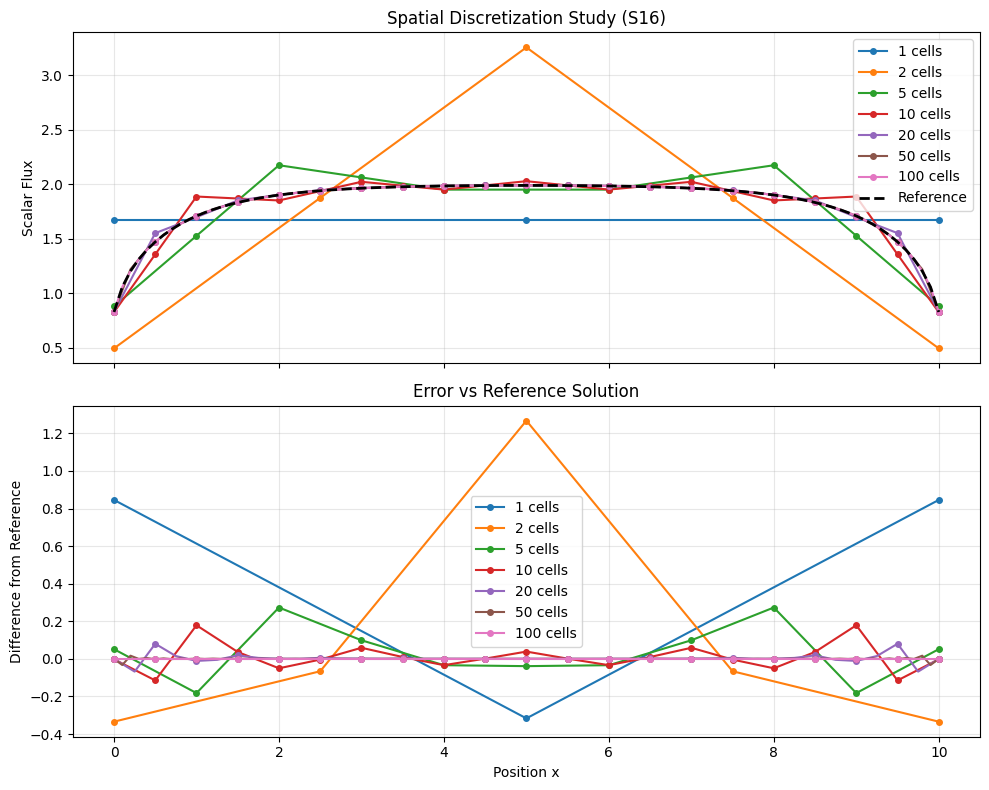

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

flux_ref, mesh_ref = results_mesh[100]

for n_cells in n_cells_list:
    flux, mesh = results_mesh[n_cells]
    ax1.plot(mesh, flux, label=f"{n_cells} cells", marker='o', markersize=4, markevery=max(1, n_cells//10))
    
    # Compute difference from reference
    flux_interp = np.interp(mesh, mesh_ref, flux_ref)
    diff = flux - flux_interp
    ax2.plot(mesh, diff, label=f"{n_cells} cells", marker='o', markersize=4, markevery=max(1, n_cells//10))

ax1.plot(mesh_ref, flux_ref, label='Reference', color='black', linestyle='--', linewidth=2)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('Scalar Flux')
ax1.set_title(f'Spatial Discretization Study (S{sn_fixed})')

ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Position x')
ax2.set_ylabel('Difference from Reference')
ax2.set_title('Error vs Reference Solution')

plt.tight_layout()
plt.show()

## Spatial Scheme Comparison

Compare Diamond, Diamond with fixup, and Step schemes.

Iterations: 12 error: 7.299066799082432e-05
Iterations: 13 error: 6.217177801404183e-05
Iterations: 13 error: 7.750527809502472e-05
Iterations: 13 error: 6.005335799286193e-05
Iterations: 14 error: 5.1715036463617636e-05
Iterations: 13 error: 8.015674594363809e-05
Iterations: 14 error: 5.124260236932798e-05
Iterations: 13 error: 8.914503455748068e-05
Iterations: 14 error: 5.144075899377043e-05
Iterations: 13 error: 9.638440296066975e-05
Iterations: 14 error: 5.1488188206327834e-05
Iterations: 14 error: 4.955009916174369e-05


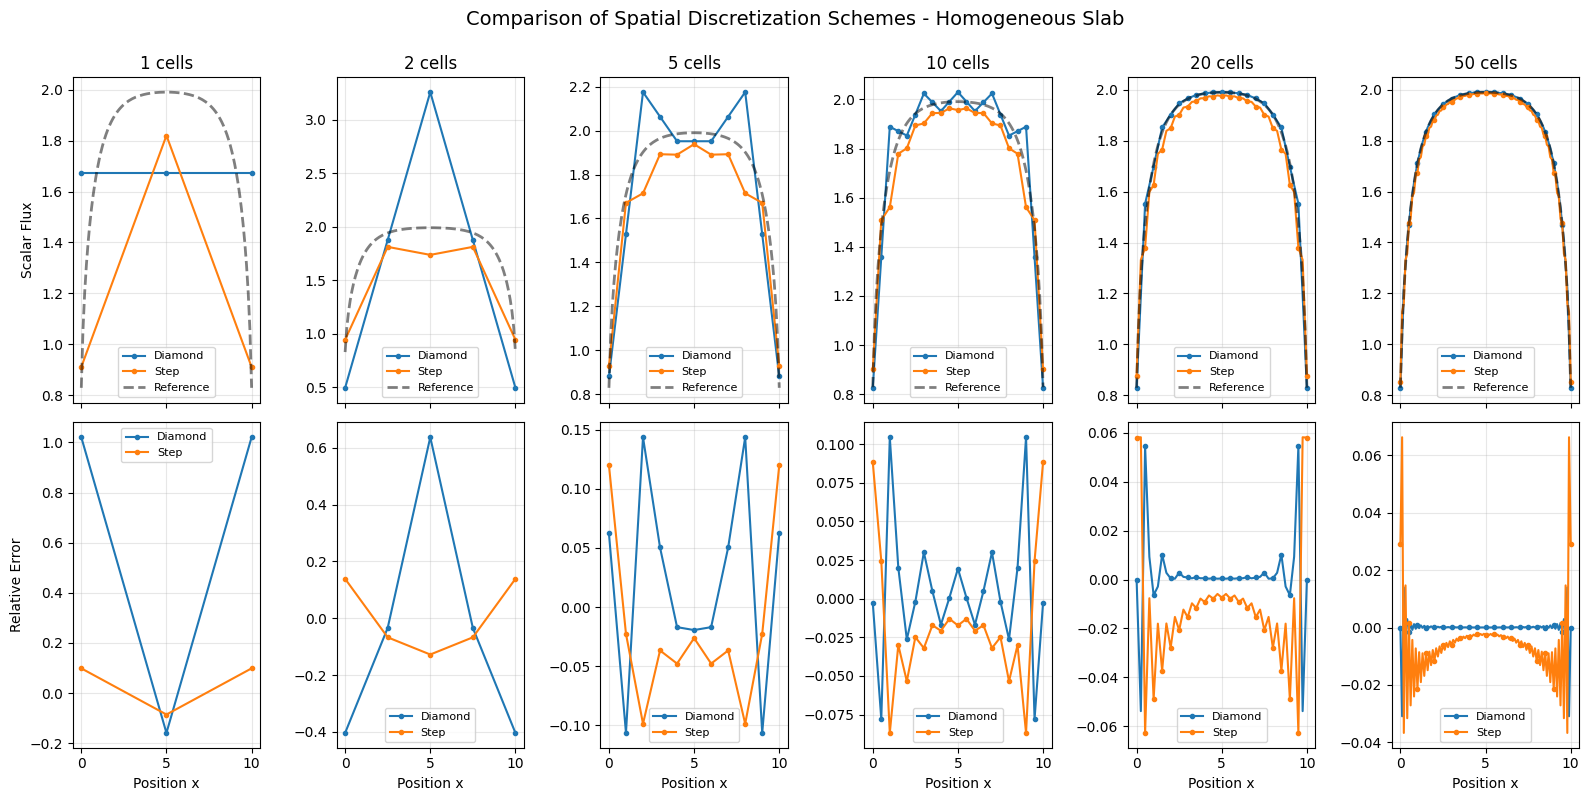

In [9]:
schemes = [Diamond(), Step()]
scheme_names = ["Diamond", "Step"]
n_cells_list = [1, 2, 5, 10, 20, 50]

fig, axes = plt.subplots(2, len(n_cells_list), figsize=(16, 8), sharex=True)

for col, n_cells in enumerate(n_cells_list):
    mesh = get_mesh(n_cells)
    
    for ii, (scheme, name) in enumerate(zip(schemes, scheme_names)):
        solver = SNSolver(geo, mesh, source, sn=16, scheme=scheme)
        flux, mesh0 = solver.solve()
        
        # First row: flux comparison
        axes[0, col].plot(mesh0, flux, label=name, marker='o', markersize=3, 
                         markevery=max(1, n_cells//10))
        
        # Second row: relative difference from reference
        flux_interp = np.interp(mesh0, mesh_ref, flux_ref)
        relative_diff = (flux - flux_interp) / np.abs(flux_interp)
        axes[1, col].plot(mesh0, relative_diff, label=name, marker='o', markersize=3,
                         markevery=max(1, n_cells//10))
    
    # Plot reference on first row
    axes[0, col].plot(mesh_ref, flux_ref, 'k--', alpha=0.5, linewidth=2, label='Reference')
    
    # Formatting for first row
    axes[0, col].legend(fontsize=8)
    axes[0, col].grid(True, alpha=0.3)
    axes[0, col].set_title(f'{n_cells} cells')
    if col == 0:
        axes[0, col].set_ylabel('Scalar Flux')
    
    # Formatting for second row
    axes[1, col].legend(fontsize=8)
    axes[1, col].grid(True, alpha=0.3)
    axes[1, col].set_xlabel('Position x')
    if col == 0:
        axes[1, col].set_ylabel('Relative Error')

fig.suptitle('Comparison of Spatial Discretization Schemes - Homogeneous Slab', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

## Convergence Analysis

Analyze the convergence rate with mesh refinement.

Iterations: 14 error: 5.149612565946704e-05
Iterations: 14 error: 5.1715036463617636e-05
Iterations: 14 error: 5.124260236932798e-05
Iterations: 14 error: 5.144075899377043e-05
Iterations: 14 error: 5.148320817505159e-05
Iterations: 14 error: 5.149355545364109e-05


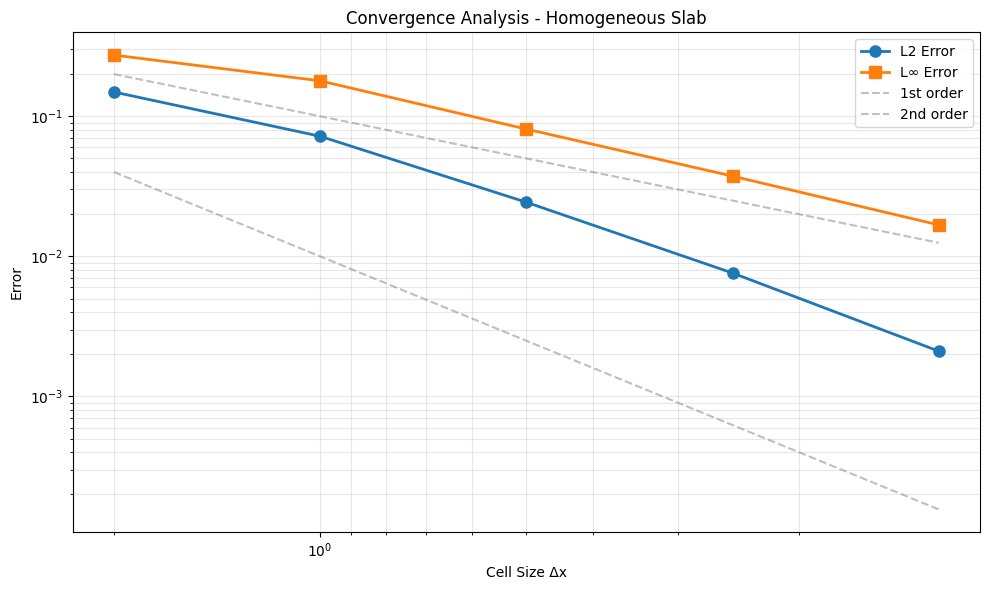


Convergence Rates:
Refinement   5 ->  10: L2 rate = 1.050, L∞ rate = 0.611
Refinement  10 ->  20: L2 rate = 1.564, L∞ rate = 1.144
Refinement  20 ->  40: L2 rate = 1.678, L∞ rate = 1.115
Refinement  40 ->  80: L2 rate = 1.853, L∞ rate = 1.157


In [10]:
mesh_obj_ref = get_mesh(160)
solver = SNSolver(geo, mesh_obj_ref, source, sn=16)
flux_ref, mesh_ref = solver.solve()
n_cells_list = [5, 10, 20, 40, 80]
errors_L2 = []
errors_Linf = []
dx_values = []
#flux_ref, mesh_ref = results_mesh[100]
for n_cells in n_cells_list:
    mesh = get_mesh(n_cells)
    solver = SNSolver(geo, mesh, source, sn=16)
    flux, mesh0 = solver.solve()
    
    # Interpolate reference to computed mesh
    flux_interp = np.interp(mesh0, mesh_ref, flux_ref)
    
    # Compute errors
    error = flux - flux_interp
    l2_error = np.sqrt(np.mean(error**2))
    linf_error = np.max(np.abs(error))
    
    errors_L2.append(l2_error)
    errors_Linf.append(linf_error)
    dx_values.append(slab_length / n_cells)

# Plot convergence
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(dx_values, errors_L2, 'o-', label='L2 Error', linewidth=2, markersize=8)
ax.loglog(dx_values, errors_Linf, 's-', label='L∞ Error', linewidth=2, markersize=8)

# Add reference slopes
dx_ref = np.array(dx_values)
ax.loglog(dx_ref, 0.1 * dx_ref, '--', alpha=0.5, label='1st order', color='gray')
ax.loglog(dx_ref, 0.01 * dx_ref**2, '--', alpha=0.5, label='2nd order', color='gray')

ax.grid(True, alpha=0.3, which='both')
ax.set_xlabel('Cell Size Δx')
ax.set_ylabel('Error')
ax.set_title('Convergence Analysis - Homogeneous Slab')
ax.legend()
ax.invert_xaxis()
plt.tight_layout()
plt.show()

# Print convergence rates
print("\nConvergence Rates:")
print("="*50)
for i in range(1, len(n_cells_list)):
    rate_L2 = np.log(errors_L2[i-1] / errors_L2[i]) / np.log(dx_values[i-1] / dx_values[i])
    rate_Linf = np.log(errors_Linf[i-1] / errors_Linf[i]) / np.log(dx_values[i-1] / dx_values[i])
    print(f"Refinement {n_cells_list[i-1]:3d} -> {n_cells_list[i]:3d}: L2 rate = {rate_L2:.3f}, L∞ rate = {rate_Linf:.3f}")